# 安裝需要的套件

In [ ]:
!pip install torch torchvision matplotlib

# Step 1: 下載和準備資料

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 下載並準備 CIFAR10 資料集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Step 2: 定義模型

In [ ]:
import torchvision.models as models
import torch.nn as nn

# 定義模型
model = models.resnet18(weights=True)
model.fc = nn.Linear(512, 10)  # 修改最後一層以適應 CIFAR10
model = model.to('cuda')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Step 3: 訓練模型（簡化版）

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 訓練模型
def train(model, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

In [ ]:
train(model)

Epoch 1/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 1, Loss: 0.4575730134325717


Epoch 2/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 2, Loss: 0.1829434335184143


Epoch 3/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 3, Loss: 0.12350854069909172


Epoch 4/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 4, Loss: 0.09356113869334808


Epoch 5/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 5, Loss: 0.07787927645770713


Epoch 6/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 6, Loss: 0.06604214790908386


Epoch 7/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 7, Loss: 0.058939437200898864


Epoch 8/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 8, Loss: 0.05353353267280704


Epoch 9/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 9, Loss: 0.04472645435213109


Epoch 10/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 10, Loss: 0.03878694108512867


# Step 4: 評估模型

In [ ]:
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [ ]:
original_accuracy = evaluate(model)

Accuracy: 80.53%


# Step 5: 模型剪枝（Pruning）

In [ ]:
import torch.nn.utils.prune as prune

def apply_pruning_importance(model, amount=0.1):
    """
    對模型進行 L1 範數基於重要性的剪枝
    :param model: 待剪枝的模型
    :param amount: 每次剪枝的比例
    """
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):  # 只剪枝卷積層
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, 'weight')  # 移除原始權重，保留剪枝結果

def fine_tune_after_pruning(model, trainloader, criterion, epochs=5, lr=0.0001):
    """
    對剪枝後的模型進行微調（Fine-tuning）
    :param model: 剪枝後的模型
    :param trainloader: 訓練資料集的 DataLoader
    :param criterion: 損失函數
    :param epochs: 微調的迭代次數
    :param lr: 微調的學習率
    """
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f"Fine-tuning Epoch {epoch + 1}/{epochs}", unit="batch"):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Fine-tuning Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# 定義 Iterative Pruning 函數
def iterative_pruning_with_finetuning(model, trainloader, criterion, initial_amount=0.1, steps=5, fine_tune_epochs=5):
    """
    使用漸進式剪枝和微調進行壓縮
    :param model: 待壓縮的模型
    :param trainloader: 訓練資料集的 DataLoader
    :param criterion: 損失函數
    :param initial_amount: 每步的剪枝比例
    :param steps: 剪枝的步數
    :param fine_tune_epochs: 每步剪枝後微調的迭代次數
    """
    for step in range(steps):
        print(f"\nPruning Step {step + 1}/{steps}, Pruning Amount: {initial_amount * (step + 1):.2f}")

        # 剪枝
        apply_pruning_importance(model, amount=initial_amount)

        # 剪枝後微調
        print("Fine-tuning after pruning...")
        fine_tune_after_pruning(model, trainloader, criterion, epochs=fine_tune_epochs)
# 設定訓練相關參數
criterion = nn.CrossEntropyLoss()

# 初始化模型（使用之前訓練好的模型）
model_pruned = model  # 這裡的 model 是預訓練好的 ResNet 或其他模型

# 開始 Iterative Pruning + Fine-tuning
iterative_pruning_with_finetuning(
    model_pruned,
    trainloader=trainloader,
    criterion=criterion,
    initial_amount=0.2,  # 每次剪枝比例 10%
    steps=5,            # 總共剪枝 5 步
    fine_tune_epochs=3  # 每次剪枝後微調 3 個 epoch
)



Pruning Step 1/5, Pruning Amount: 0.20
Fine-tuning after pruning...


Fine-tuning Epoch 1/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 1, Loss: 0.10200485176718829


Fine-tuning Epoch 2/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 2, Loss: 0.0883433716478841


Fine-tuning Epoch 3/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 3, Loss: 0.07736057450737605

Pruning Step 2/5, Pruning Amount: 0.40
Fine-tuning after pruning...


Fine-tuning Epoch 1/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 1, Loss: 0.07365900504729136


Fine-tuning Epoch 2/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 2, Loss: 0.06385519471533997


Fine-tuning Epoch 3/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 3, Loss: 0.05656474589309453

Pruning Step 3/5, Pruning Amount: 0.60
Fine-tuning after pruning...


Fine-tuning Epoch 1/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 1, Loss: 0.054372246296483254


Fine-tuning Epoch 2/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 2, Loss: 0.05403277153313598


Fine-tuning Epoch 3/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 3, Loss: 0.04991804425845213

Pruning Step 4/5, Pruning Amount: 0.80
Fine-tuning after pruning...


Fine-tuning Epoch 1/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 1, Loss: 0.0416624108159705


Fine-tuning Epoch 2/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 2, Loss: 0.043449327185014


Fine-tuning Epoch 3/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 3, Loss: 0.04107375194549637

Pruning Step 5/5, Pruning Amount: 1.00
Fine-tuning after pruning...


Fine-tuning Epoch 1/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 1, Loss: 0.0314258037837963


Fine-tuning Epoch 2/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 2, Loss: 0.032443153619518515


Fine-tuning Epoch 3/3:   0%|          | 0/782 [00:00<?, ?batch/s]

Fine-tuning Epoch 3, Loss: 0.03532881371464337


# Step 6: 壓縮後模型的評估

In [ ]:
compressed_accuracy = evaluate(model_pruned)

Accuracy: 71.29%


# Step 7: 可視化結果

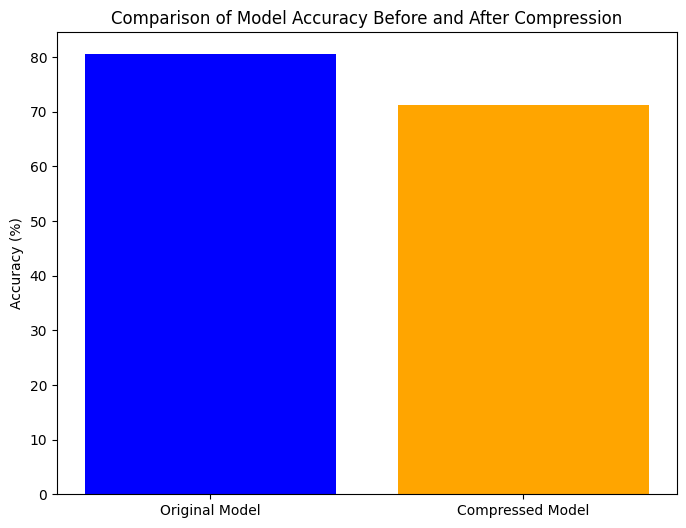

In [ ]:
# 視覺化比較
plt.figure(figsize=(8, 6))
plt.bar(['Original Model', 'Compressed Model'], [original_accuracy * 100, compressed_accuracy * 100], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracy Before and After Compression')
plt.show()


# Step 8: 模型結構與參數量比較

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

original_params = count_parameters(models.resnet18(weights=True))
compressed_params = count_parameters(model_pruned)

print(f'Original Model Parameters: {original_params}')
print(f'Compressed Model Parameters: {compressed_params}')
print(f'Compression Ratio: {original_params/compressed_params :.2f}')


Original Model Parameters: 11689512
Compressed Model Parameters: 11181642
Compression Ratio: 1.05
